<a href="https://colab.research.google.com/github/naokityokoyama/infnet/blob/main/infnet_projeto_codigos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install prophet
import warnings

     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 184kB 35.1MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6639693 sha256=7fb4ed992896b8ad75fa58ef92b3f624650840f3c7a2f0ec8cdc2f1a72540275
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/naokityokoyama/infnet/main/train.csv')

In [ ]:
df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [9]:
dados = df[df['Store']==1]

In [10]:
dados = dados.drop(['Store',	'Dept'], axis=1).groupby('Date').sum().reset_index()

In [11]:
mapa = {0:False, 71:True, 72:True, 73:True}
dados.IsHoliday = dados.IsHoliday.map(mapa)

In [12]:
dados.shape

(143, 3)

Convert Datetime

In [13]:
dados['Date'] = pd.to_datetime(dados['Date'])

In [14]:
test = dados.tail(12)

In [15]:
test.head()

,Date,Weekly_Sales,IsHoliday
131,2012-08-10,1592409.97,False
132,2012-08-17,1597868.05,False
133,2012-08-24,1494122.38,False
134,2012-08-31,1582083.40,False
135,2012-09-07,1661767.33,True


In [16]:
treino = dados.iloc[0:131]

In [17]:
treino.head()

,Date,Weekly_Sales,IsHoliday
0,2010-02-05,1643690.90,False
1,2010-02-12,1641957.44,True
2,2010-02-19,1611968.17,False
3,2010-02-26,1409727.59,False
4,2010-03-05,1554806.68,False


In [ ]:
test.info(), treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 131 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          12 non-null     datetime64[ns]
 1   Weekly_Sales  12 non-null     float64       
 2   IsHoliday     12 non-null     bool          
dtypes: bool(1), datetime64[ns](1), float64(1)
memory usage: 336.0 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          131 non-null    datetime64[ns]
 1   Weekly_Sales  131 non-null    float64       
 2   IsHoliday     131 non-null    bool          
dtypes: bool(1), datetime64[ns](1), float64(1)
memory usage: 2.3 KB


(None, None)

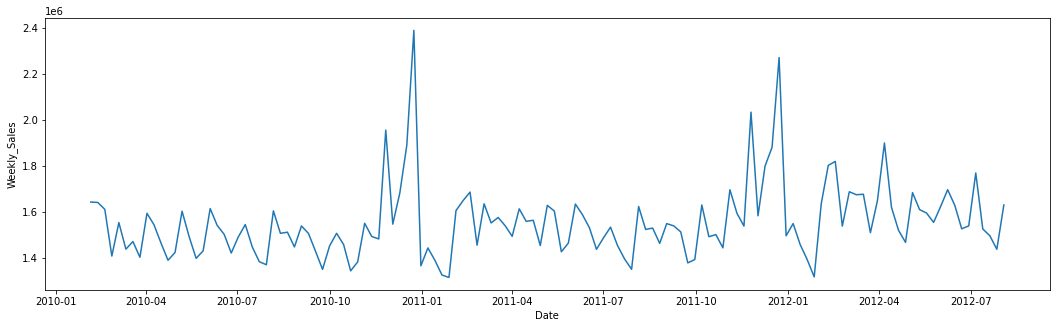

In [ ]:
plt.figure(figsize=(18,5))
sns.lineplot(data=treino, x='Date', y='Weekly_Sales')

Tendencia

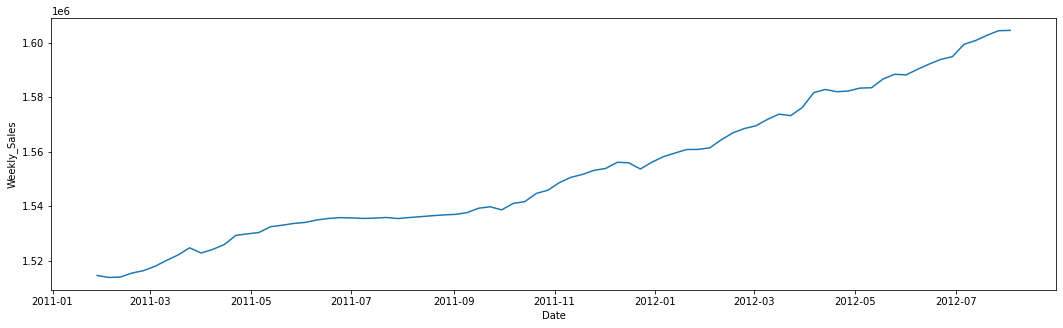

In [ ]:
#media movel 52 semanas
plt.figure(figsize=(18,5))
sns.lineplot(data=treino, x='Date', y=treino.Weekly_Sales.rolling(52).mean())

Sazonalidade

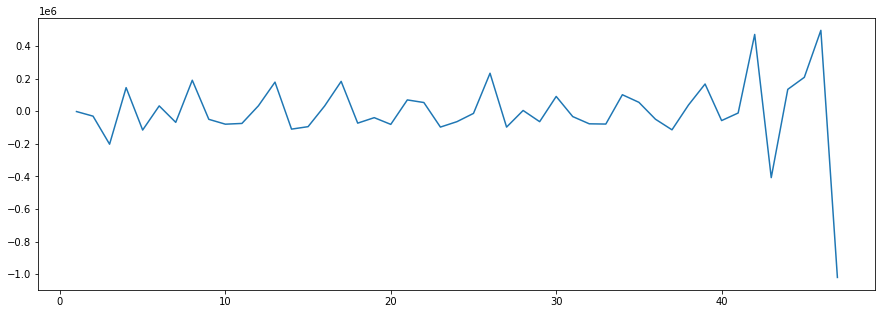

In [ ]:
filtro = treino.Date <= '2010-12-31'	 
treino[filtro].Weekly_Sales.diff().plot(figsize=(15,5))

In [ ]:
treino[filtro].Weekly_Sales.diff()

0            NaN
1       -1733.46
2      -29989.27
3     -202240.58
4      145079.09
5     -115265.09
6       32974.20
7      -68085.87
8      190538.36
9      -49549.75
10     -79360.25
11     -74802.16
12      33844.59
13     178854.41
14    -109703.62
15     -94589.43
16      32407.88
17     183454.76
18     -72963.62
19     -39277.03
20     -80572.46
21      69706.54
22      53656.04
23     -97135.26
24     -63873.72
25     -13078.60
26     233505.18
27     -97254.02
28       4842.73
29     -63937.57
30      91020.61
31     -32702.84
32     -77082.02
33     -78587.64
34     101538.47
35      54910.43
36     -48830.83
37    -113955.10
38      38755.22
39     167450.06
40     -57179.79
41     -10695.31
42     471839.93
43    -407590.33
44     134580.48
45     208420.67
46     496915.27
47   -1020630.19
Name: Weekly_Sales, dtype: float64

FB Prophet

In [ ]:
X = pd.DataFrame(treino[['Date', 'Weekly_Sales']])
X = X.rename(columns={'Date':'ds', 'Weekly_Sales':'y'})
X['ds'] = pd.to_datetime(X['ds'])

In [ ]:
m = Prophet(yearly_seasonality=True)
m.add_country_holidays(country_name='US')
m.fit(X)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=12, freq='w')

In [ ]:
future.tail(12)

,ds
131,2012-08-05
132,2012-08-12
133,2012-08-19
134,2012-08-26
135,2012-09-02
136,2012-09-09
137,2012-09-16
138,2012-09-23
139,2012-09-30
140,2012-10-07


In [ ]:
test

,Date,Weekly_Sales,IsHoliday
131,2012-08-10,1592409.97,False
132,2012-08-17,1597868.05,False
133,2012-08-24,1494122.38,False
134,2012-08-31,1582083.40,False
135,2012-09-07,1661767.33,True
136,2012-09-14,1517428.87,False
137,2012-09-21,1506126.06,False
138,2012-09-28,1437059.26,False
139,2012-10-05,1670785.97,False
140,2012-10-12,1573072.81,False


In [ ]:
forecast = m.predict(future)

In [ ]:
round(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]).tail(12)

,ds,yhat,yhat_lower,yhat_upper
131,2012-08-05,1573707.0,1447842.0,1694387.0
132,2012-08-12,1605547.0,1472286.0,1729848.0
133,2012-08-19,1629796.0,1511914.0,1755913.0
134,2012-08-26,1634310.0,1505065.0,1765992.0
135,2012-09-02,1610275.0,1481542.0,1735544.0
136,2012-09-09,1566224.0,1434522.0,1682486.0
137,2012-09-16,1530485.0,1399265.0,1649046.0
138,2012-09-23,1528882.0,1398394.0,1647664.0
139,2012-09-30,1556627.0,1435026.0,1680109.0
140,2012-10-07,1579578.0,1459411.0,1703087.0


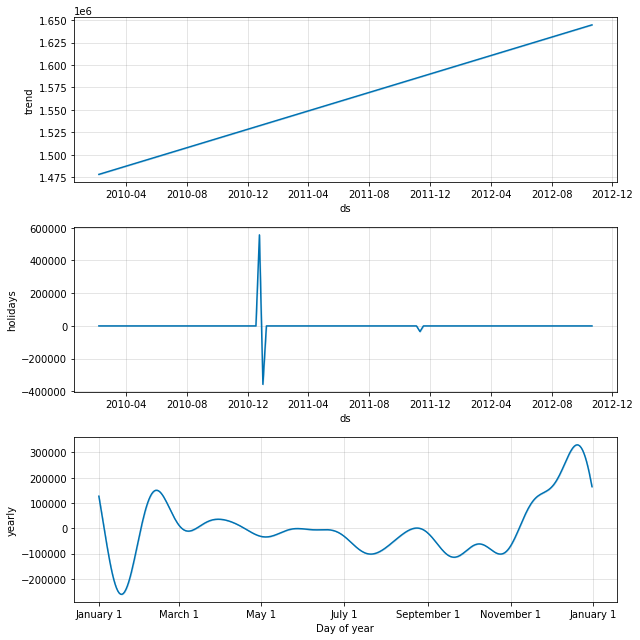

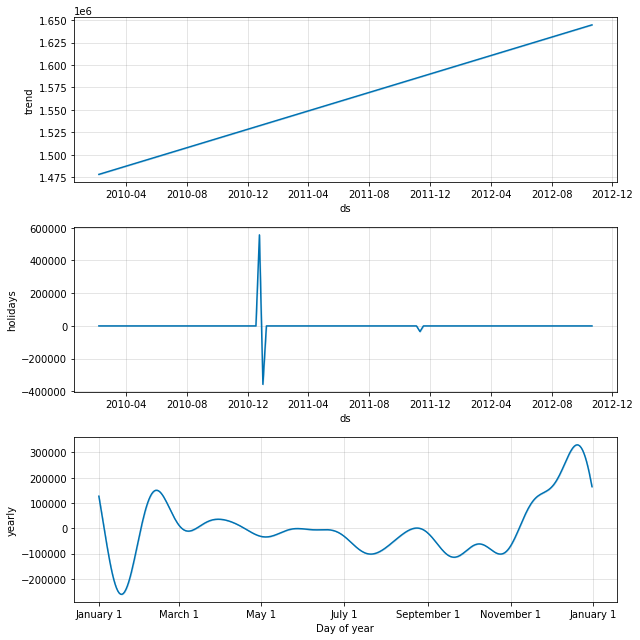

In [ ]:
 m.plot_components(forecast)

In [ ]:
plot_plotly(m, forecast)

In [ ]:
fore = round(forecast['yhat']).tail(12)

In [ ]:
resultado_final_prophet_loja1 = pd.concat([test, fore], axis=1).drop('IsHoliday', axis=1)
resultado_final_prophet_loja1['diff'] = resultado_final_prophet_loja1['Weekly_Sales'] -  resultado_final_prophet_loja1['yhat']
resultado_final_prophet_loja1['%'] =  (resultado_final_prophet_loja1['diff']  / resultado_final_prophet_loja1['Weekly_Sales'])*100  

In [ ]:
resultado_final_prophet_loja1

,Date,Weekly_Sales,yhat,diff,%
131,2012-08-10,1592409.97,1573707.0,18702.97,1.174507
132,2012-08-17,1597868.05,1605547.0,-7678.95,-0.480575
133,2012-08-24,1494122.38,1629796.0,-135673.62,-9.080489
134,2012-08-31,1582083.40,1634310.0,-52226.60,-3.301128
135,2012-09-07,1661767.33,1610275.0,51492.33,3.098649
136,2012-09-14,1517428.87,1566224.0,-48795.13,-3.215645
137,2012-09-21,1506126.06,1530485.0,-24358.94,-1.617324
138,2012-09-28,1437059.26,1528882.0,-91822.74,-6.389628
139,2012-10-05,1670785.97,1556627.0,114158.97,6.832651
140,2012-10-12,1573072.81,1579578.0,-6505.19,-0.413534


In [ ]:
plot_components_plotly(m, forecast)


RNN

In [ ]:
base_treino = treino['Weekly_Sales'].values
base_teste = test['Weekly_Sales'].values 

In [ ]:
min = MinMaxScaler()
base_treino = base_treino.reshape(-1,1)
base_treino = min.fit_transform(base_treino)
base_treino = base_treino[:,0]

In [1]:
previsores = []
preco_real = []

for i in range(12, treino.shape[0]):
  previsores.append(base_treino[i-12:i])
  preco_real.append(base_treino[i])



NameError: ignored

In [ ]:
previsores, preco_real = np.array(previsores), np.array(preco_real)

In [ ]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [ ]:
previsores.shape[1]

12

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units=100, return_sequences=True, input_shape = (12,1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1, activation='linear'))

regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

regressor.fit(previsores, preco_real, epochs=2000, batch_size=15)

In [ ]:
preco_real_test = test['Weekly_Sales'].values
base_completa = pd.concat([treino['Weekly_Sales'], test['Weekly_Sales']], axis=0)

In [ ]:
entradas = base_completa[len(base_completa)-len(test)-12:].values

In [ ]:
entradas = entradas.reshape(-1,1)
entradas = min.fit_transform(entradas)

In [ ]:
entradas = entradas[:,0]

In [ ]:
x_test = []
for i in range(12, test.shape[0]+12):
  x_test.append(entradas[i-12:i])

In [ ]:
x_test = np.array(x_test)  

In [ ]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
previsoes = regressor.predict(x_test)

In [ ]:
previsoes = min.inverse_transform(previsoes)

In [ ]:
plt.plot(preco_real_test, color='r', label='Preco Real')
plt.plot(previsoes, color='b', label='Previsao')
plt.title('Previsao venda Walmart')
plt.ylabel('Venda Walmart')
plt.legend()
plt.show()

NameError: ignored